C:\Users\zisha\AppData\Local\Temp\ipykernel_16516\390370538.py:33: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('wptw.csv')


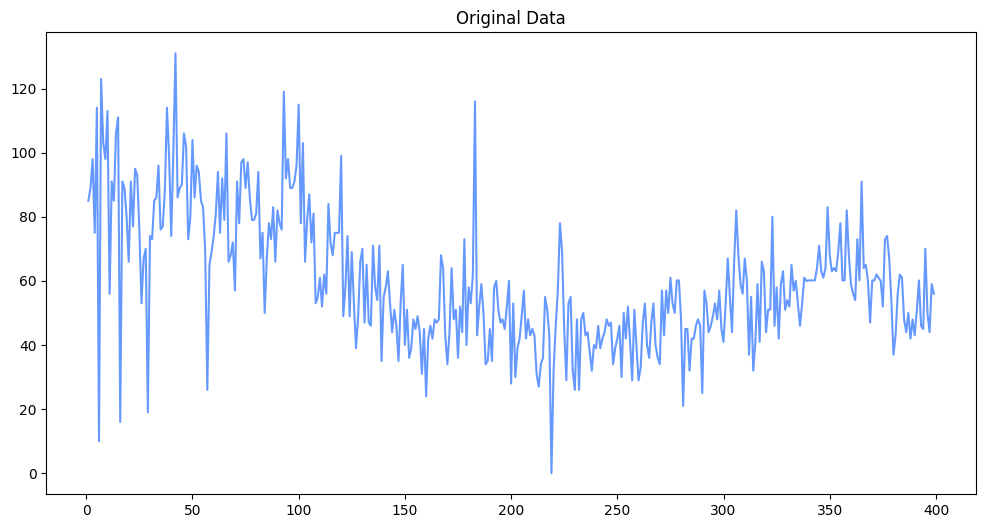

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from copy import deepcopy as dc

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Prepare the dataset
df = pd.read_csv('wptw.csv')
selected_df = df[(df['UPC'] == 3700063527) & (df['STORE'] == 112)][['WEEK', 'MOVE']]

selected_df['MOVE'] = selected_df['MOVE'][(selected_df['MOVE'] - selected_df['MOVE'].mean()).abs() < 3 * selected_df['MOVE'].std()]
selected_df = selected_df.dropna()

max_week = selected_df['WEEK'].max()
all_weeks = range(1, max_week + 1)
missing_weeks = set(all_weeks) - set(selected_df['WEEK'])
missing_data = [{'WEEK': week, 'MOVE': selected_df['MOVE'].mean()} for week in missing_weeks]
missing_df = pd.DataFrame(missing_data)
selected_df = pd.concat([selected_df, missing_df]).sort_values('WEEK').reset_index(drop=True)
selected_df['MOVE'] = selected_df['MOVE'].fillna(selected_df['MOVE'].mean())

data = selected_df

# Set device (GPU if available, otherwise CPU)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(data['WEEK'], data['MOVE'], color='#6699ff')
plt.title("Original Data")
plt.show()

# Prepare the dataframe for LSTM
lookback = 7
shifted_df = dc(data)
shifted_df.set_index('WEEK', inplace=True)

for i in range(1, lookback+1):
    shifted_df[f'Move(t-{i})'] = shifted_df['MOVE'].shift(i)

shifted_df.dropna(inplace=True)


In [6]:
# Scale the data
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df.to_numpy())

print(shifted_df_as_np.shape)
X = shifted_df_as_np[:, 1:]
print(X.shape)
y = shifted_df_as_np[:, 0]

X = dc(np.flip(X, axis=1))

(392, 8)
(392, 7)


In [16]:


# Split the data into training and testing sets
split_index = int(len(X) * 0.80)

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

# Create PyTorch datasets and data loaders
class SalesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [17]:

batch_size = 16
train_loader = DataLoader(SalesDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(SalesDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# Train and evaluate an ensemble of LSTM models with random initializations and architectures
num_models = 30
models = []

train_losses = []  # Store training losses for each model
test_losses = []   # Store testing losses for each model

# Store validation losses for each model
validation_losses = []

for i in range(num_models):
    # Randomly choose the number of hidden units, stacked layers, and learning rate
    hidden_size = np.random.choice([4, 8, 16])
    num_layers = np.random.choice([1, 2, 3])
    learning_rate = 10 ** np.random.uniform(-4, -2)

    model = LSTM(1, hidden_size, num_layers)
    model.to(device)

    # Randomly initialize the parameters
    for param in model.parameters():
        nn.init.uniform_(param, -0.08, 0.08)

    models.append((model, learning_rate))

# Training and evaluation loop
num_epochs = 30
loss_function = nn.MSELoss()

for model_idx, (model, learning_rate) in enumerate(models):
    print(f"Training Ensemble Model {model_idx + 1} with Learning Rate: {learning_rate}")

    model_losses_train = []  # Store training losses during training for each model

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train(True)
        running_loss = 0.0
        
        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_index % 10 == 9:
                avg_loss_across_batches = running_loss / 10
                print(f'Ensemble Model {model_idx + 1}, Epoch {epoch + 1}, Batch {batch_index + 1}, Loss: {avg_loss_across_batches:.3f}')
                model_losses_train.append(avg_loss_across_batches)
                running_loss = 0.0
    
    train_losses.append(model_losses_train)

    # Evaluate the model on the test set
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    test_losses.append(avg_loss_across_batches)
    validation_losses.append(avg_loss_across_batches)

    print(f'Ensemble Model {model_idx + 1}, Validation Loss: {avg_loss_across_batches:.3f}')
    print('***************************************************')


Training Ensemble Model 1 with Learning Rate: 0.001552213052442875
Ensemble Model 1, Epoch 1, Batch 10, Loss: 0.132
Ensemble Model 1, Epoch 1, Batch 20, Loss: 0.123
Ensemble Model 1, Epoch 2, Batch 10, Loss: 0.124
Ensemble Model 1, Epoch 2, Batch 20, Loss: 0.116
Ensemble Model 1, Epoch 3, Batch 10, Loss: 0.102
Ensemble Model 1, Epoch 3, Batch 20, Loss: 0.131
Ensemble Model 1, Epoch 4, Batch 10, Loss: 0.103
Ensemble Model 1, Epoch 4, Batch 20, Loss: 0.120
Ensemble Model 1, Epoch 5, Batch 10, Loss: 0.123
Ensemble Model 1, Epoch 5, Batch 20, Loss: 0.095
Ensemble Model 1, Epoch 6, Batch 10, Loss: 0.115
Ensemble Model 1, Epoch 6, Batch 20, Loss: 0.095
Ensemble Model 1, Epoch 7, Batch 10, Loss: 0.103
Ensemble Model 1, Epoch 7, Batch 20, Loss: 0.080
Ensemble Model 1, Epoch 8, Batch 10, Loss: 0.071
Ensemble Model 1, Epoch 8, Batch 20, Loss: 0.081
Ensemble Model 1, Epoch 9, Batch 10, Loss: 0.057
Ensemble Model 1, Epoch 9, Batch 20, Loss: 0.080
Ensemble Model 1, Epoch 10, Batch 10, Loss: 0.061
E

Top 5 Models:
Model 3, Validation Loss: 0.020
Model 10, Validation Loss: 0.020
Model 12, Validation Loss: 0.020
Model 24, Validation Loss: 0.020
Model 29, Validation Loss: 0.021
Model 14, Validation Loss: 0.021
Model 2, Validation Loss: 0.021
Model 23, Validation Loss: 0.021
Model 9, Validation Loss: 0.021
Model 27, Validation Loss: 0.021


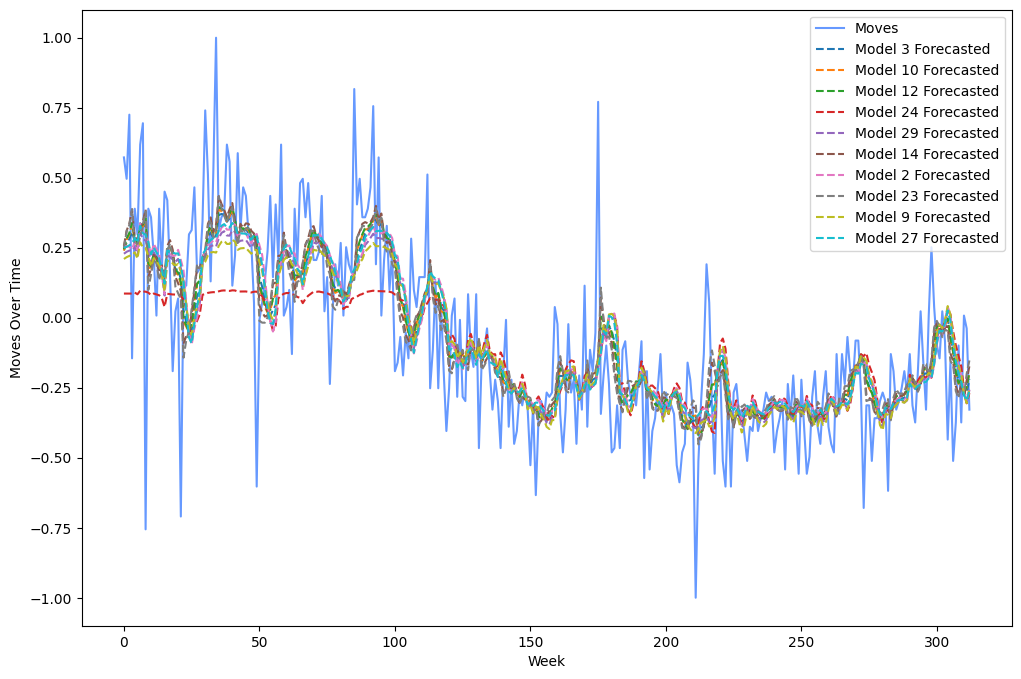

In [18]:

# Find the top 5 models based on validation loss
top_models_indices = np.argsort(validation_losses)[:10]
top_models = [models[i] for i in top_models_indices]

# Print indices and corresponding validation losses of the top 5 models
print('Top 10 Models:')
for i, idx in enumerate(top_models_indices):
    print(f'Model {idx + 1}, Validation Loss: {validation_losses[idx]:.3f}')

# Generate predictions for all models on the training data
all_predictions = []

for model, _ in top_models:  # Use top 5 models for predictions
    with torch.no_grad():
        predicted = model(X_train.to(device)).to('cpu').numpy()
        all_predictions.append(predicted)

# Plot the actual moves and forecasted moves for all models
plt.figure(figsize=(12, 8))
plt.plot(y_train, label='Moves', color='#6699ff')

for i, predicted in enumerate(all_predictions):
    plt.plot(predicted, label=f'Model {top_models_indices[i] + 1} Forecasted', linestyle='dashed')

plt.xlabel('Week')
plt.ylabel('Moves Over Time')
plt.legend()
plt.show()

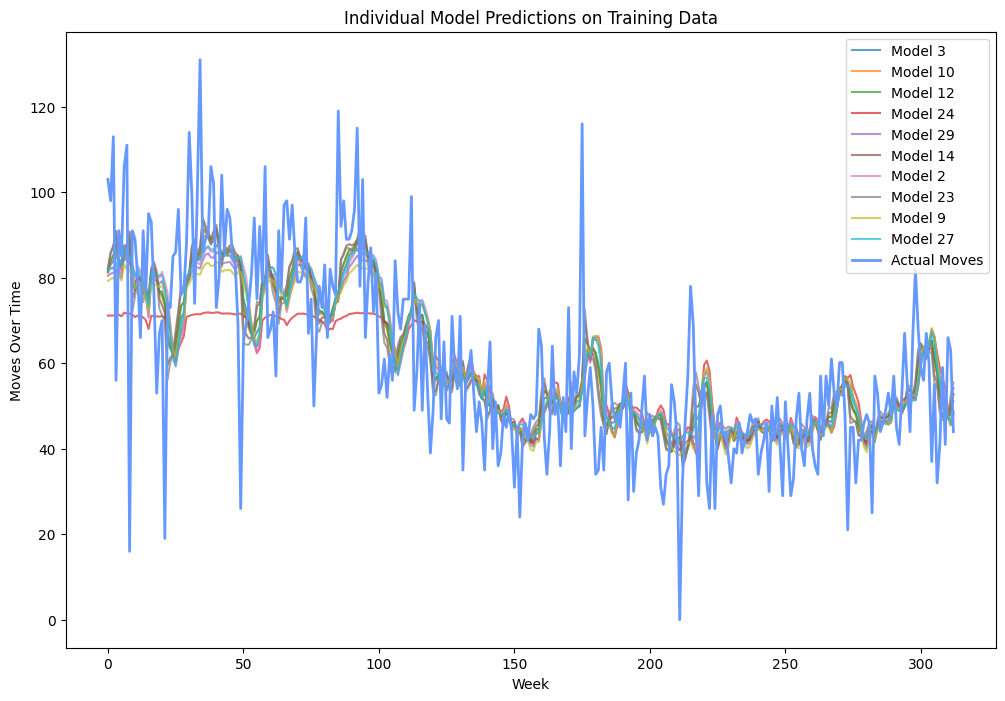

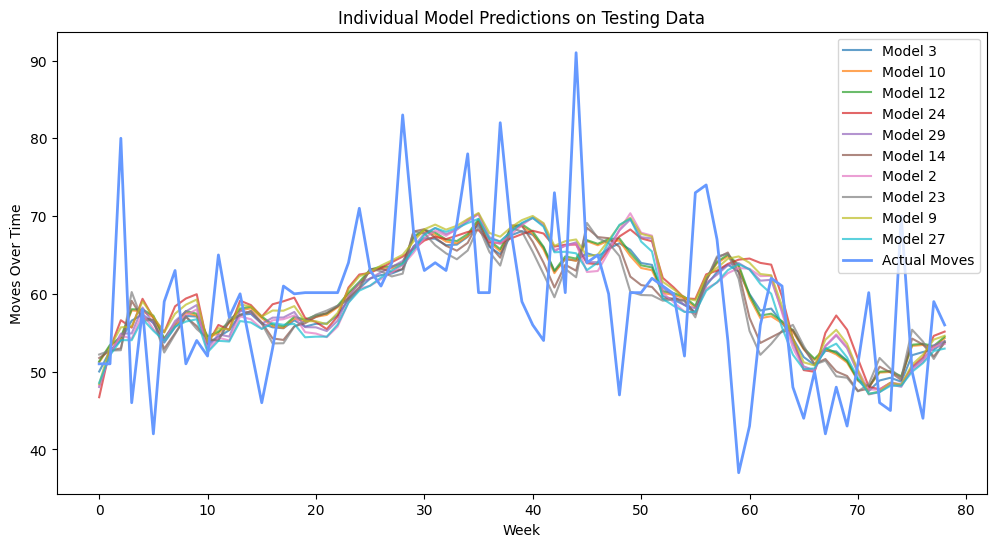

In [19]:
# Visualize individual model predictions on training data
plt.figure(figsize=(12, 8))

for model_idx, (model, _) in enumerate(top_models):  # Use top 10 models for predictions
    with torch.no_grad():
        model.to(device)
        model_predictions = model(X_train.to(device)).detach().cpu().numpy().flatten()

    dummies = np.zeros((X_train.shape[0], lookback + 1))
    dummies[:, 0] = model_predictions
    dummies = scaler.inverse_transform(dummies)

    train_predictions = dc(dummies[:, 0])

    plt.plot(train_predictions, label=f'Model {top_models_indices[model_idx] + 1}', alpha=0.7)

# Inverse transform the actual values
dummies = np.zeros((X_train.shape[0], lookback + 1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)
new_y_train = dc(dummies[:, 0])

plt.plot(new_y_train, label='Actual Moves', color='#6699ff', linewidth=2)
plt.xlabel('Week')
plt.ylabel('Moves Over Time')
plt.title("Individual Model Predictions on Training Data")
plt.legend()
plt.show()

# Visualize individual model predictions on testing data
plt.figure(figsize=(12, 6))

for model_idx, (model, _) in enumerate(top_models):  # Use top 5 models for predictions
    with torch.no_grad():
        model.to(device)
        model_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

    dummies = np.zeros((X_test.shape[0], lookback + 1))
    dummies[:, 0] = model_predictions
    dummies = scaler.inverse_transform(dummies)

    test_predictions = dc(dummies[:, 0])

    plt.plot(test_predictions, label=f'Model {top_models_indices[model_idx] + 1}', alpha=0.7)

# Inverse transform the actual values
dummies = np.zeros((X_test.shape[0], lookback + 1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)
new_y_test = dc(dummies[:, 0])

plt.plot(new_y_test, label='Actual Moves', color='#6699ff', linewidth=2)
plt.xlabel('Week')
plt.ylabel('Moves Over Time')
plt.title("Individual Model Predictions on Testing Data")
plt.legend()
plt.show()

# Combine predictions using weighted average for the top models
ensemble_weights = np.ones(len(top_models)) / len(top_models)  # Equal weights for simplicity, you can adjust this based on performance

ensemble_predictions = np.zeros_like(y_test, dtype=float)

for model_idx, (model, _) in enumerate(top_models):
    with torch.no_grad():
        model.to(device)
        model_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

    dummies = np.zeros((X_test.shape[0], lookback + 1))
    dummies[:, 0] = model_predictions
    dummies = scaler.inverse_transform(dummies)

    ensemble_predictions += ensemble_weights[model_idx] * dummies[:, 0] if len(dummies.shape) == 1 else ensemble_weights[model_idx] * dummies[:, 0][:, None]

# Inverse transform the actual values
dummies = np.zeros((X_test.shape[0], lookback + 1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)
new_y_test = dc(dummies[:, 0])

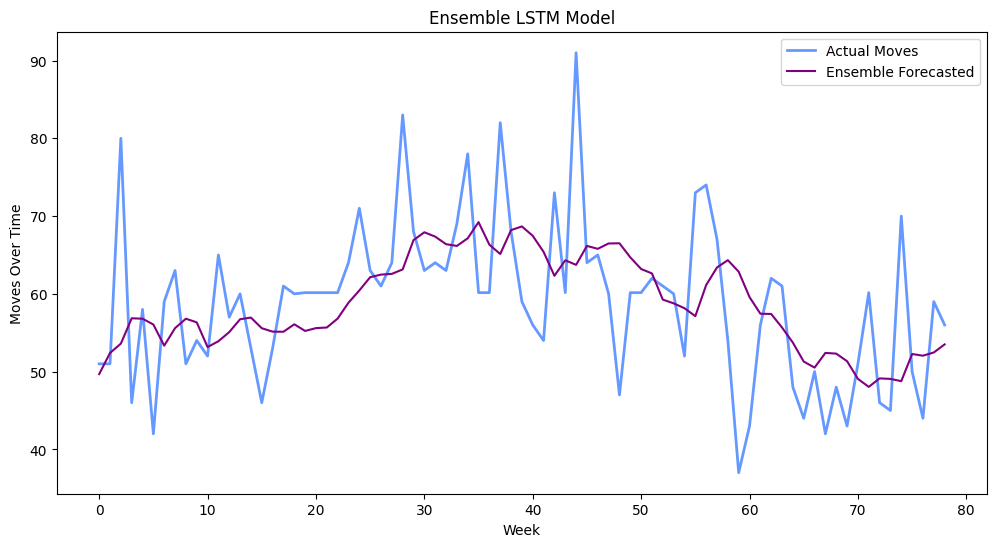

Ensemble Model Metrics:
MSE: 87.69127078323233
MAE: 6.967906317537365
RMSE: 9.364361739234145


In [20]:
# Combine predictions using weighted average
ensemble_weights = np.ones(num_models) / num_models  # Equal weights for simplicity, you can adjust this based on performance, for example, inverse of validation loss

ensemble_predictions = np.zeros_like(y_test, dtype=float)

for model_idx, (model, _) in enumerate(models):
    with torch.no_grad():
        model.to(device)
        model_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

    dummies = np.zeros((X_test.shape[0], lookback + 1))
    dummies[:, 0] = model_predictions
    dummies = scaler.inverse_transform(dummies)

    ensemble_predictions += ensemble_weights[model_idx] * dummies[:, 0] if len(dummies.shape) == 1 else ensemble_weights[model_idx] * dummies[:, 0][:, None]

# Inverse transform the actual values
dummies = np.zeros((X_test.shape[0], lookback + 1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)
new_y_test = dc(dummies[:, 0])

# Visualize the ensemble predictions
plt.figure(figsize=(12, 6))
plt.plot(new_y_test, label='Actual Moves', color='#6699ff', linewidth=2)
plt.plot(ensemble_predictions, label='Ensemble Forecasted', color='purple')
plt.xlabel('Week')
plt.ylabel('Moves Over Time')
plt.title("Ensemble LSTM Model")
plt.legend()
plt.show()

# Report performance metrics for the ensemble
ensemble_mse = mean_squared_error(new_y_test, ensemble_predictions)
ensemble_mae = mean_absolute_error(new_y_test, ensemble_predictions)
ensemble_rmse = math.sqrt(ensemble_mse)

print('Ensemble Model Metrics:')
print('MSE: ' + str(ensemble_mse))
print('MAE: ' + str(ensemble_mae))
print('RMSE: ' + str(ensemble_rmse))
